In [27]:
import numpy as np
import random
import sklearn.utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt;

import numpy as np
import matplotlib.pyplot as plt


In [2]:
def flip(classified_sample):
    if classified_sample == 1:
        classified_sample = 0
    else:
        classified_sample = 1
    return classified_sample

In [3]:
n_training_samples = 7500
num_iterations = 1000
num_samples = 300
misclassification_prob1=0.5
misclassification_prob2=0.1
test_class = []
for i in range(0,n_training_samples):
    test_class.append(random.randrange(0,2,1))

test_class = np.array(test_class)


In [4]:
def get_results(sample_classifier1, sample_classifier2, sample_true_class):
    n01 = 0
    n10 = 0
    n00 = 0
    n11 = 0

    for i in range(0, len(sample_classifier1)):
        if (sample_true_class[i] == sample_classifier1[i]) and (sample_true_class[i] != sample_classifier2[i]):
            n01 = n01 + 1
        if ((sample_true_class[i] == sample_classifier2[i]) and sample_true_class[i] != sample_classifier1[i]):
            n10 = n10 + 1
        if (sample_true_class[i] != sample_classifier1[i]) and (sample_true_class[i] != sample_classifier2[i]):
            n00 = n00 + 1
        if (sample_true_class[i] == sample_classifier1[i]) and (sample_true_class[i] == sample_classifier2[i]):
            n11 = n11 + 1
    return n01, n10, n00, n11

def sample_dataset_classes(test_class, num_samples):
    sample_true_class = []
    for j in range(0, num_samples):
        index = random.randrange(0, 7500, 1)
        sample_true_class.append(test_class[index])
    return np.array(sample_true_class)


def sample_classifiers(sample_true_class, min, max):
    sample_classifier1 = []
    sample_classifier2 = []
    for j in range(0, int(num_samples / 2)):
        sample_classifier1.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob1 else flip(
            sample_true_class[j]))
        sample_classifier2.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob2 else flip(
            sample_true_class[j]))
    for j in range(int(num_samples / 2), num_samples):
        sample_classifier1.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob2 else flip(
            sample_true_class[j]))
        sample_classifier2.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob1 else flip(
            sample_true_class[j]))

    return np.array(sample_classifier1), np.array(sample_classifier2)


In [21]:
def mc_nemar(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                test_size=0.3)
    n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                     sample_true_class[test_indices])
    mcnemar = ((abs(n01 - n10) - 1) ** 2) / (n01 + n10)
    if (mcnemar > border_value):
        return True
    else:
        return False

#test for difference of two proportions 1.96 z statistic
def pair_z(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                test_size=0.3)
    n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                     sample_true_class[test_indices])
    pA = (n00 + n01) / (len(test_indices))
    pB = (n00 + n10) / (len(test_indices))
    p = (pA + pB) / 2
    Z = (pA - pB) / math.sqrt((2 * p * (1 - p)) / (len(test_indices)))
    if (abs(Z) > border_value):
        return True
    else:
        return False

#t statistics, 29 stupnjeva slobode, 2.04523
def resampled_t_test(sample_true_class, border_value):
    p_a = []
    p_b = []
    for i in range(0, 30):
        train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                    test_size=0.3)
        sample_classifier1, sample_classifier2 = sample_classifiers(sample_true_class, 0, 0)
        n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                         sample_true_class[test_indices])
        p_a.append((n00 + n01) / (len(test_indices)))
        p_b.append((n00 + n10) / (len(test_indices)))
    result = stats.ttest_ind(p_a, p_b)
    if (abs(result[0]) > border_value):
        return True
    else:
        return False

#kfold t test
def kfold_t_test(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    p_a = []
    p_b = []
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    kf.get_n_splits(sample_classifier1)
    for train_index, test_index in kf.split(sample_true_class, sample_true_class):
        n01, n10, n00, n11 = get_results(sample_classifier1[test_index], sample_classifier2[test_index],
                                         sample_true_class[test_index])
        p_a.append((n00 + n01) / (len(test_index)))
        p_b.append((n00 + n10) / (len(test_index)))
    result = stats.ttest_ind(p_a, p_b)
    if (abs(result[0]) > border_value):
        return True
    else:
        return False

#5x2cv test 2.776 mora biti da bi bilo signifikantno
def t_test5x2cv(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    variance = []
    kf = KFold(n_splits=2, shuffle=True)
    kf.get_n_splits(sample_classifier1)
    for i in range(0, 5):
        fold = 0
        counter = 0
        p_1 = 0
        p_2 = 0

        for train_index, test_index in kf.split(sample_classifier1):
            n01, n10, n00, n11 = get_results(sample_classifier1[test_index], sample_classifier2[test_index],
                                             sample_true_class[test_index])
            pA = (n00 + n01) / (len(test_index))
            pB = (n00 + n10) / (len(test_index))
            fold = fold + 1
            if (counter == 0):
                p_1 = pA - pB
            if (counter == 1):
                p_2 = pA - pB
            counter = counter + 1
        p_error = (p_1 + p_2) / 2
        variance.append(((p_1 - p_error) ** 2) + ((p_2 - p_error) ** 2))

    T = p_1 / (math.sqrt(np.mean(np.array(variance))))
    if (abs(T) > border_value):
        return True
    else:
        return False


In [33]:
mc_nemar_errors = 0
pair_z_errors = 0
resampled_t_errors = 0
kfold_t_errors = 0
t_test5x2_errors = 0

for i in range(0, 1000):
    sample_true_class = sample_dataset_classes(test_class, num_samples)
    sample_classifier1, sample_classifier2 = sample_classifiers(sample_true_class, -0.02, 0.02)
    n01, n10, n00, n11 = get_results(sample_classifier1, sample_classifier2, sample_true_class)
    if (mc_nemar(sample_true_class, sample_classifier1, sample_classifier2, 3.841)):
        mc_nemar_errors += 1
    if (pair_z(sample_true_class, sample_classifier1, sample_classifier2, 1.96)):
        pair_z_errors += 1
    if (resampled_t_test(sample_true_class, 2.04523)):
        resampled_t_errors += 1
    if (kfold_t_test(sample_true_class, sample_classifier1, sample_classifier2, 2.262)):
        kfold_t_errors += 1
    if (t_test5x2cv(sample_true_class, sample_classifier1, sample_classifier2, 2.571)):
        t_test5x2_errors += 1


In [34]:
print(mc_nemar_errors)
print(pair_z_errors)
print(resampled_t_errors)
print(kfold_t_errors)
print(t_test5x2_errors)


21
51
62
14
12


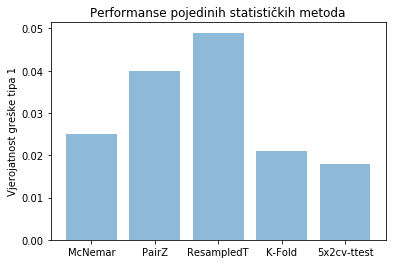

In [ ]:
objects = ('McNemar', 'PairZ', 'ResampledT', 'K-Fold', '5x2cv-ttest')
y_pos = np.arange(len(objects))
performance = [mc_nemar_errors/1000,pair_z_errors/1000,resampled_t_errors/1000,kfold_t_errors/1000,t_test5x2_errors/1000]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Vjerojatnost greške tipa 1')
plt.title('Performanse pojedinih statističkih metoda')
plt.savefig("rezultati.png")
plt.show()

